# Lab 06 Live Demo: AE, VAE, DDPM, and Latent Diffusion (SpaceNet-7 Patches)

This notebook demonstrates:
- Training an Autoencoder (AE) and a Variational Autoencoder (VAE).
- Training a pixel-space DDPM and sampling images.
- Training and sampling a Latent Diffusion Model (LDM) using a frozen VAE.

Assumes the notebook is run from the local Lab06 folder and uses local relative paths (e.g., "./sample_data"). No shell/system calls are used.

In [1]:
# Setup: local imports and device
import sys, os
from pathlib import Path

# Ensure current directory (.) is importable
if '.' not in sys.path: sys.path.insert(0, '.')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# Data: use local './sample_data' if present; otherwise build a synthetic in-memory dataset.
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
import torch

def has_images(p: Path):
    if not p.exists(): return False
    for ext in ('.png','.jpg','.jpeg','.tif','.tiff'):
        if any(p.glob(f'*{ext}')): return True
    return False

image_size = 128
data_dir = Path('./sample_data')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'

if has_images(train_dir) and has_images(val_dir):
    print('Using local patches at', str(data_dir))
    from data.sn7_dataset import get_datasets
    train_ds, val_ds = get_datasets(str(data_dir), image_size=image_size)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
else:
    print('No local patches found; generating synthetic in-memory dataset')
    def make_synth(n: int, size: int = 128):
        x = torch.zeros(n, 3, size, size)
        for i in range(n):
            # background noise
            x[i] = torch.rand(3, size, size) * 0.2
            # draw a few random rectangles
            for _ in range(3):
                h = torch.randint(size//8, size//3, (1,)).item()
                w = torch.randint(size//8, size//3, (1,)).item()
                y = torch.randint(0, size-h, (1,)).item()
                x0 = torch.randint(0, size-w, (1,)).item()
                color = torch.rand(3,1,1)*0.8 + 0.2
                x[i, :, y:y+h, x0:x0+w] = color
        return x
    n_train, n_val = 96, 24
    xtr = make_synth(n_train, image_size)
    xva = make_synth(n_val, image_size)
    ytr = torch.zeros(n_train, dtype=torch.long)
    yva = torch.zeros(n_val, dtype=torch.long)
    train_loader = DataLoader(TensorDataset(xtr, ytr), batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(TensorDataset(xva, yva), batch_size=16, shuffle=False, num_workers=0)
image_size

# Also persist synthetic dataset to ./sample_data for use by scripts
try:
    from data.util import ensure_or_create_synth_dataset
    ensure_or_create_synth_dataset(str(data_dir), size=image_size, n_train=96, n_val=24)
    print('Ensured on-disk dataset at', str(data_dir))
except Exception as e:
    print('Warning: could not write dataset to disk:', e)


No local patches found; generating synthetic in-memory dataset
Ensured on-disk dataset at sample_data


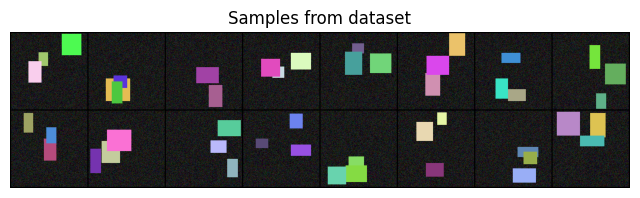

In [3]:
# Preview a batch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
batch = next(iter(train_loader));
xb = batch[0] if isinstance(batch,(list,tuple)) else batch
grid = make_grid(xb[:16], nrow=8)
plt.figure(figsize=(8,4)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title('Samples from dataset'); plt.show()


## Autoencoder (AE) quick train

AE Epoch 1/1: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


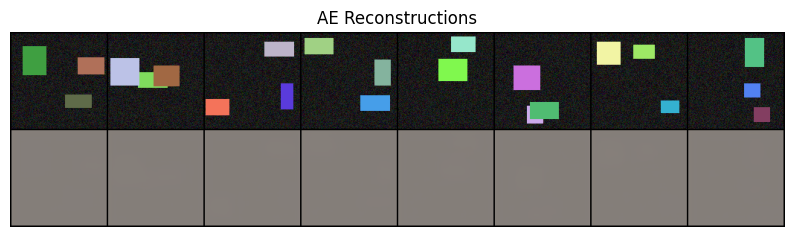

In [4]:
from models.ae import AutoEncoder
import torch.nn as nn
try:
    from tqdm import tqdm
except Exception:
    def tqdm(it, **kwargs):
        return it

ae = AutoEncoder(in_channels=3, base=32, latent_channels=64).to(device)
opt = torch.optim.AdamW(ae.parameters(), lr=2e-4)
crit = nn.L1Loss()

for epoch in range(1):
    ae.train()
    pbar = tqdm(train_loader, total=min(len(train_loader), 50), desc='AE Epoch 1/1')
    for i, batch in enumerate(pbar):
        x = batch[0] if isinstance(batch,(list,tuple)) else batch
        if i >= 50: break
        x = x.to(device)
        x_hat, _ = ae(x)
        loss = crit(x_hat, x)
        opt.zero_grad(); loss.backward(); opt.step()

# Reconstructions
ae.eval()
with torch.no_grad():
    batch = next(iter(val_loader));
x = batch[0] if isinstance(batch,(list,tuple)) else batch
    x = x.to(device)
    x_hat, _ = ae(x)

def show_side_by_side(x, x_hat, n=8, title='AE Reconstructions'):
    import torch
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt
    x = x[:n].cpu()
    x_hat = x_hat[:n].cpu()
    grid = torch.cat([x, x_hat], dim=0)
    grid = make_grid(grid, nrow=n)
    plt.figure(figsize=(10,4)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title(title); plt.show()

show_side_by_side(x, x_hat, n=8)


## VAE quick train and sample

VAE Epoch 1/1: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


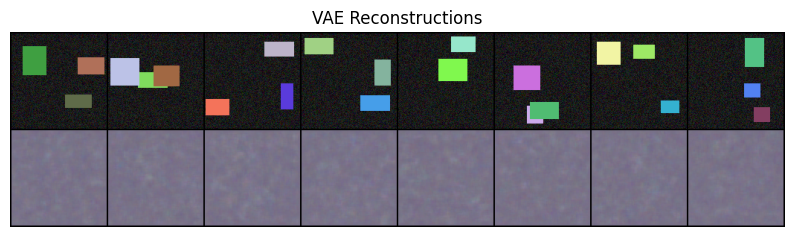

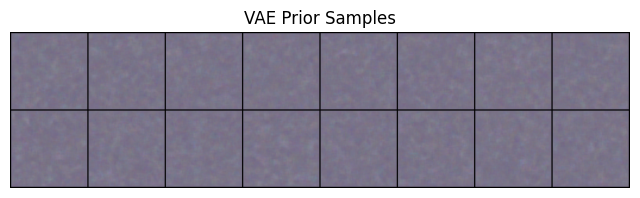

'checkpoints/vae_demo.pt'

In [5]:
from models.vae import VAE
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(it, **kwargs):
        return it

vae = VAE(in_channels=3, base=32, latent_channels=64).to(device)
opt = torch.optim.AdamW(vae.parameters(), lr=2e-4)
recon_loss = nn.L1Loss()
beta_kl = 1e-3

for epoch in range(1):
    vae.train()
    pbar = tqdm(train_loader, total=min(len(train_loader), 50), desc='VAE Epoch 1/1')
    for i, batch in enumerate(pbar):
        x = batch[0] if isinstance(batch,(list,tuple)) else batch
        if i >= 50: break
        x = x.to(device)
        x_hat, mu, logvar = vae(x)
        kl = VAE.kl_loss(mu, logvar)
        rec = recon_loss(x_hat, x)
        loss = rec + beta_kl * kl
        opt.zero_grad(); loss.backward(); opt.step()

# Reconstructions
vae.eval()
with torch.no_grad():
    batch = next(iter(val_loader));
x = batch[0] if isinstance(batch,(list,tuple)) else batch
    x = x.to(device)
    x_hat, mu, logvar = vae(x)
    show_side_by_side(x, x_hat, n=8, title='VAE Reconstructions')

# Prior samples in latent space
with torch.no_grad():
    z = torch.randn_like(mu)
    x_synth = vae.decoder(z).clamp(0,1)
    grid = make_grid(x_synth[:16].cpu(), nrow=8)
    plt.figure(figsize=(8,4)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title('VAE Prior Samples'); plt.show()

# Save checkpoint for LDM use (local path)
ckpt_dir = Path('./checkpoints')
ckpt_dir.mkdir(parents=True, exist_ok=True)
vae_ckpt = ckpt_dir / 'vae_demo.pt'
torch.save({'model': vae.state_dict(), 'args': {'latent_channels': 64, 'base': 32}}, vae_ckpt)
str(vae_ckpt)


## Pixel-space DDPM (quick)

DDPM Epoch 1/1: 100%|██████████| 6/6 [00:51<00:00,  8.54s/it]


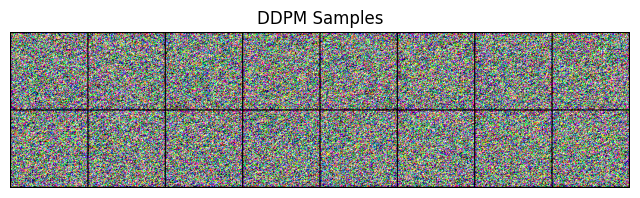

In [6]:
from models.unet import UNet
from models.ddpm import LinearNoiseScheduler
import torch.nn as nn
try:
    from tqdm import tqdm
except Exception:
    def tqdm(it, **kwargs):
        return it
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

ddpm_timesteps = 200
unet = UNet(in_channels=3, base=32, time_dim=128).to(device)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-4)
sched = LinearNoiseScheduler(timesteps=ddpm_timesteps, device=device)
mse = nn.MSELoss()

for epoch in range(1):
    unet.train()
    pbar = tqdm(train_loader, total=min(len(train_loader), 50), desc='DDPM Epoch 1/1')
    for i, batch in enumerate(pbar):
        x = batch[0] if isinstance(batch,(list,tuple)) else batch
        if i >= 50: break
        x = (x.to(device) * 2) - 1  # [-1,1]
        t = torch.randint(0, sched.timesteps, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = sched.add_noise(x, noise, t)
        pred = unet(x_t, t)
        loss = mse(pred, noise)
        opt.zero_grad(); loss.backward(); opt.step()

# Sample a few images
with torch.no_grad():
    x = sched.sample(unet, (16, 3, image_size, image_size))
    x = ((x.clamp(-1,1) + 1) * 0.5).cpu()
    grid = make_grid(x, nrow=8)
    plt.figure(figsize=(8,4)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title('DDPM Samples'); plt.show()


## Latent Diffusion Model (LDM): train on VAE latents

In [7]:
# Load frozen VAE encoder/decoder
from ldm.latent_autoencoder import LatentAutoencoder
vae_wrap = LatentAutoencoder('./checkpoints/vae_demo.pt', device=device)
latent_channels = vae_wrap.latent_channels
latent_channels

64

In [8]:
# Latent Diffusion (using library class)
import torch.nn as nn
from models.ddpm import LinearNoiseScheduler
from ldm.ldm import LatentDiffusion
try:
    from tqdm import tqdm
except Exception:
    def tqdm(it, **kwargs):
        return it

ldm = LatentDiffusion(latent_channels=latent_channels, time_dim=128, base=32).to(device)
opt = torch.optim.AdamW(ldm.parameters(), lr=1e-4)
sched_lat = LinearNoiseScheduler(timesteps=200, device=device)
mse = nn.MSELoss()

for epoch in range(1):
    ldm.train()
    pbar = tqdm(train_loader, total=min(len(train_loader), 50), desc='LDM Epoch 1/1')
    for i, batch in enumerate(pbar):
        x = batch[0] if isinstance(batch,(list,tuple)) else batch
        if i >= 50: break
        x = x.to(device)
        with torch.no_grad():
            z0 = vae_wrap.encode(x)
        t = torch.randint(0, sched_lat.timesteps, (z0.size(0),), device=device).long()
        noise = torch.randn_like(z0)
        z_t = sched_lat.add_noise(z0, noise, t)
        pred = ldm(z_t, t)
        loss = mse(pred, noise)
        opt.zero_grad(); loss.backward(); opt.step()


LDM Epoch 1/1: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


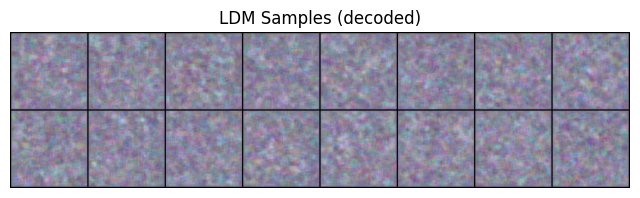

In [9]:
# Latent sampling then decode to images
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
@torch.no_grad()
def sample_ldm_images(model, vae_wrap, n=16, latent_h=None, latent_w=None):
    if latent_h is None or latent_w is None:
        batch = next(iter(val_loader));
x = batch[0] if isinstance(batch,(list,tuple)) else batch
        x = x.to(device)
        z = vae_wrap.encode(x)
        _, c, h, w = z.shape
        latent_h, latent_w = h, w
    z = torch.randn(n, latent_channels, latent_h, latent_w, device=device)
    for i in reversed(range(0, sched_lat.timesteps)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        z = sched_lat.p_sample(model, z, t, i)
    x = vae_wrap.decode(z).clamp(0,1)
    return x

imgs = sample_ldm_images(ldm, vae_wrap, n=16)
grid = make_grid(imgs.cpu(), nrow=8)
plt.figure(figsize=(8,4)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title('LDM Samples (decoded)'); plt.show()
